# **Creating and Analyzing a Custom Dataset Using NASA's Open APIs**

Welcome to the "Creating and Analyzing a Custom Dataset Using NASA's Open APIs" project. In this project, we will harness NASA's publicly available Asteroids - NeoWs API to create our own dataset, perform data cleaning, and conduct comprehensive data analysis. The project is divided into three key phases:


 1. **Data Acquisition:** Retrieve data from NASA's Asteroids - NeoWs API. This involves using GET methods to access the relevant information on asteroids and near-Earth objects.

 2. **Data Cleaning and Transformation:** Process the collected data to ensure its quality and consistency. This phase includes cleaning and transforming the data into a suitable format for analysis.

 3. **Data Analysis:** Conduct a thorough analysis of the cleaned and transformed dataset. This includes applying various analytical techniques to uncover insights, identify trends, and visualize the data effectively.

**The dataset will include the following variables:**

- **'id':** A unique identifier for each asteroid.

- **'name':** The name or designation of the asteroid.

- **'absolute_magnitude_h':** The absolute magnitude of the asteroid, which indicates its brightness.
- **'estimated_diameter_min':** The minimum estimated diameter of the asteroid, measured in kilometers.
- **'estimated_diameter_max':** The maximum estimated diameter of the asteroid, measured in kilometers.
- **'is_potentially_hazardous_asteroid':** A boolean value indicating whether the asteroid is classified as potentially hazardous.
- **'close_approach_date_full':** The full date and time when the asteroid is expected to make a close approach to Earth.
- **'kilometers_per_hour':** The speed of the asteroid in kilometers per hour at the time of its close approach.
- **'miss_distance':** The distance, measured in kilometers, by which the asteroid will miss Earth during its close approach.
- **'is_sentry_object':** A boolean value indicating whether the asteroid is being monitored by NASA's Sentry system for potential future impact risk.

This comprehensive dataset will enable us to analyze various aspects of asteroids, including their physical characteristics, potential hazards, and trajectories, providing valuable insights into these celestial objects.

### **Guiding Questions**

**1.** Is there a correlation between the risk of impact with Earth and whether an asteroid is classified as potentially hazardous?

**2.** Is there a correlation between momentum (calculated as speed x diameter) and whether an asteroid is classified as potentially hazardous?

**3.** Is there a correlation between the brightness (absolute magnitude) and the speed of the asteroids?

**4.** How many hazardous asteroids are there within the selected dates, and what are their characteristics?

**5.** Which day has the highest number of asteroids, and how many are there on that day?

**6.** What are the average miss distances of the asteroids?

### **Importing Necessary Libraries:**

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

## **1 - Data Acquisition**

In this section, we will:

- **Create a DataFrame:** Set up a DataFrame to store the retrieved data. This DataFrame will serve as the foundation for our dataset.

- **Write a Function for API Requests:** Develop a function that uses the GET method to send requests to the NASA Asteroids - NeoWs API. This function will handle the communication with the API and retrieve the data.

- **Develop a Function for Date Range Requests:** Implement an additional function that utilizes the previously created API request function to fetch data for specified date ranges. This function will allow us to obtain the data in a single operation for the desired time period.

These steps will enable us to efficiently acquire the necessary data from the API and store it in our DataFrame for further processing.

In [2]:
df_ = pd.DataFrame(columns=['id', 'name', 'absolute_magnitude_h', 'estimated_diameter_min', 'estimated_diameter_max', 'is_potentially_hazardous_asteroid','close_approach_date_full', 'kilometers_per_hour', 'miss_distance', 'is_sentry_object' ])

In [6]:
def get_data(date, dataframe, api_key):

    date = date.strftime('%Y-%m-%d')

    #We are providing the URL and parameters of the API we will use.
    url = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={date}&end_date={date}&api_key={api_key}"
    params = {
        'start_date' : date,
        'end_date': date,
        'api_key': api_key
    } 

    #This line sends a GET request to the specified URL with the provided parameters. The response from the API is stored in the response variable.
    response = requests.get(url, params=params)


    #This block checks if the API response status code is 200, indicating a successful request. 
    #If successful, the raw data from the response is stored in the data variable as a string. 
    #Then, json.loads(data) converts the string into a JSON object, which is stored in the json_data variable.
    if response.status_code == 200:
        data = response.text
        json_data = json.loads(data)

        #We are iterating through the JSON data row by row to insert it into the dataframe
        for item in json_data['near_earth_objects'][date]:
            id = item['id']
            name = item['name']
            absolute_magnitude_h = item['absolute_magnitude_h']
            estimated_diameter_min = item['estimated_diameter']['meters']['estimated_diameter_min']
            estimated_diameter_max = item['estimated_diameter']['meters']['estimated_diameter_max']
            is_potentially_hazardous_asteroid = item['is_potentially_hazardous_asteroid']
            close_approach_date_full = item['close_approach_data'][0]['close_approach_date_full']
            kilometers_per_hour = item['close_approach_data'][0]['relative_velocity']['kilometers_per_hour']
            miss_distance = item['close_approach_data'][0]['miss_distance']['kilometers']
            is_sentry_object = item['is_sentry_object']

            new_row = {
            'id': id, 
            'name': name, 
            'absolute_magnitude_h':absolute_magnitude_h, 
            'estimated_diameter_min':estimated_diameter_min,
            'estimated_diameter_max':estimated_diameter_max,
            'is_potentially_hazardous_asteroid':is_potentially_hazardous_asteroid,
            'close_approach_date_full':close_approach_date_full,
            'kilometers_per_hour':kilometers_per_hour,
            'miss_distance':miss_distance,
            'is_sentry_object':is_sentry_object
            }

            dataframe = dataframe.append(new_row, ignore_index=True)

        dataframe['close_approach_date_full'] = pd.to_datetime(dataframe['close_approach_date_full'])
        dataframe = dataframe.sort_values(by = 'close_approach_date_full').reset_index(drop=True)
        
        return dataframe #We return the dataframe containing the results obtained from the API as the output of the function.

    else:
        print("Error:", response.status_code)

In [7]:
def get_data_with_ranges(start_date, end_date, df, api_key):
    
    # Converting start_date and end_date from strings to datetime objects.
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    #Iterating through each day from start_date to end_date.
    while start_date <= end_date:
        df = get_data(start_date, df, api_key) #Calling the get_data function for each day and updating the DataFrame with new data.
        start_date += timedelta(days=1) #Incrementing start_date by one day for the next iteration.
    
    return df #Returning the updated dataframe containing data for the specified date range.


In [ ]:
#Importing the API Key from config file and assigning the key to a variable.
from config import API_KEY
api_key = API_KEY

#Giving the date ranges and arguments of the function and gathering the data.
df_ = get_data_with_ranges('2024-06-01','2024-07-01',df_,api_key)

In [9]:
df = df_.copy() #We make a copy of the dataframe in case we need the original, so we won’t have to make another request to the API.

In [10]:
df

,id,name,absolute_magnitude_h,estimated_diameter_min,estimated_diameter_max,is_potentially_hazardous_asteroid,close_approach_date_full,kilometers_per_hour,miss_distance,is_sentry_object
0,54445199,(2024 KB1),28.25,5.950521,13.305769,False,2024-06-01 00:43:00,39798.8458271435,364228.447333216,True
1,54439713,(2024 JP1),25.82,18.220277,40.741778,False,2024-06-01 04:14:00,17015.9615231724,7072635.858283796,False
2,54439432,(2024 JC1),25.10,25.383703,56.759685,False,2024-06-01 05:44:00,17338.9978219896,5782214.370485133,False
3,54376459,(2023 OE5),26.36,14.208721,31.771665,False,2024-06-01 06:03:00,11944.3997071163,20472428.073195739,False
4,3738911,(2015 YA1),24.50,33.462237,74.823838,False,2024-06-01 07:46:00,58044.4213094903,51635501.186763173,False
...,...,...,...,...,...,...,...,...,...,...
456,3348144,(2006 TL),23.90,44.111820,98.637028,False,2024-07-01 10:08:00,68712.9591371407,46743093.944732311,False
457,54430150,(2024 ES2),26.40,13.949382,31.191767,False,2024-07-01 13:28:00,34790.6359261614,64093480.907442117,False
458,3803907,(2018 HO),26.77,11.763999,26.305101,False,2024-07-01 14:30:00,8051.0568089262,44550291.373189498,False
459,3130460,(2002 MR3),21.40,139.493823,311.917671,True,2024-07-01 14:34:00,76913.0143515947,11881871.666203729,False


## **2 - Data Cleaning & Transformation:**

In this section, we perform several key operations to prepare the data for analysis:

- **Convert Variables to Appropriate Data Types:** We ensure that all variables are converted to their correct data types. This step is crucial for accurate analysis and operations on the data.

- **Remove Decimal Points:** We eliminate fractional parts from numerical values where necessary, standardizing the data for consistency.

- **Create a Variable for Average Estimated Values:** We introduce a new variable to calculate the average of estimated values. This helps in handling any missing or imprecise data points.

- **Creating a Variable for Momentum:** Since momentum is typically calculated as the product of mass and velocity, and mass data is not available in this dataset, we use diameter as a substitute for mass. By multiplying the diameter by the velocity, we approximate momentum based on the available data. This approach provides a useful, though indirect, measure of momentum given the constraints of the dataset.

These steps are essential for cleaning and transforming the data, making it ready for meaningful analysis.

In [11]:
#As we can see, not all columns have the desired data types.
for column in df:
    print(df[column].dtype)

object
object
float64
float64
float64
object
datetime64[ns]
object
object
object


In [12]:
#We convert specific columns to their appropriate data types: binary columns to integers and numerical columns to floats for accurate analysis.
df['is_potentially_hazardous_asteroid'] = df['is_potentially_hazardous_asteroid'].astype(int)
df['is_sentry_object'] = df['is_sentry_object'].astype(int)
df['kilometers_per_hour'] = df['kilometers_per_hour'].astype(float)
df['miss_distance'] = df['miss_distance'].astype(float)

In [13]:
#The data types are now in the desired format.
for column in df:
    print(df[column].dtype)

object
object
float64
float64
float64
int32
datetime64[ns]
float64
float64
int32


In [14]:
#Creating the average value for estimated values.
df['estimated_diameter'] = (df['estimated_diameter_max'] + df['estimated_diameter_min'])/2
df = df.drop(columns = ['estimated_diameter_max', 'estimated_diameter_min'])

In [15]:
#When calculating momentum, we convert the diameter from meters to kilometers.
df['momentum'] = (df['estimated_diameter'] / 1000) * df['kilometers_per_hour']

In [16]:
#We round all float columns to 2 decimal places for consistency and precision in the dataset.
for column in df.select_dtypes(include=['float']):
    df[column] = df[column].round(2)

In [17]:
df

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,close_approach_date_full,kilometers_per_hour,miss_distance,is_sentry_object,estimated_diameter,momentum
0,54445199,(2024 KB1),28.25,0,2024-06-01 00:43:00,39798.85,364228.45,1,9.63,383.19
1,54439713,(2024 JP1),25.82,0,2024-06-01 04:14:00,17015.96,7072635.86,0,29.48,501.65
2,54439432,(2024 JC1),25.10,0,2024-06-01 05:44:00,17339.00,5782214.37,0,41.07,712.14
3,54376459,(2023 OE5),26.36,0,2024-06-01 06:03:00,11944.40,20472428.07,0,22.99,274.60
4,3738911,(2015 YA1),24.50,0,2024-06-01 07:46:00,58044.42,51635501.19,0,54.14,3142.70
...,...,...,...,...,...,...,...,...,...,...
456,3348144,(2006 TL),23.90,0,2024-07-01 10:08:00,68712.96,46743093.94,0,71.37,4904.35
457,54430150,(2024 ES2),26.40,0,2024-07-01 13:28:00,34790.64,64093480.91,0,22.57,785.24
458,3803907,(2018 HO),26.77,0,2024-07-01 14:30:00,8051.06,44550291.37,0,19.03,153.25
459,3130460,(2002 MR3),21.40,1,2024-07-01 14:34:00,76913.01,11881871.67,0,225.71,17359.71


## **3 - Data Analysis**

In this section, we perform a detailed analysis of the dataset to answer the following guiding questions:

**1.** *Is there a correlation between the risk of impact with Earth and whether an asteroid is classified as potentially hazardous?*

**2.** *Is there a correlation between momentum (calculated as speed x diameter) and whether an asteroid is classified as potentially hazardous?*

**3.** *Is there a correlation between the brightness (absolute magnitude) and the speed of the asteroids?*

**4.** *How many hazardous asteroids are there within the selected dates, and what are their characteristics?*

**5.** *Which day has the highest number of asteroids, and how many are there on that day?*

**6.** *What are the average miss distances of the asteroids?*

These analyses provide valuable insights into asteroid characteristics and their potential impact, helping in assessing risks and understanding asteroid behavior.

To achieve more consistent results in correlation calculations, let's will scale the variables using StandardScaler.

In [58]:
scaler = StandardScaler()
df['scaled_momentum'] = scaler.fit_transform(df[['momentum']])
df['scaled_velocity'] = scaler.fit_transform(df[['kilometers_per_hour']])

#Since brightness increases as the `absolute_magnitude` value decreases, we subtract the scaled `absolute_magnitude` from 1 to make it more meaningful for analysis."
df['scaled_magnitude'] = scaler.fit_transform(df[['absolute_magnitude_h']])
df['scaled_magnitude'] = 1 - df['scaled_magnitude']


We will need to calculate the Pearson correlation coefficient for several questions, so let's create a function with dataframe columns as arguments that computes the coefficient.

In [54]:
def pearson_correlation(df, column1, column2):
    pearson_corr, _ = pearsonr(df[column1], df[column2])
    print(f"Pearson Correlation Coefficient between '{column1}' and '{column2}': {pearson_corr}")
    return pearson_corr

**1. Is there a correlation between the risk of impact with Earth and whether an asteroid is classified as potentially hazardous?**

In [55]:
pearson_corr = pearson_correlation(df, 'is_potentially_hazardous_asteroid', 'is_sentry_object')

Pearson Correlation Coefficient between 'is_potentially_hazardous_asteroid' and 'is_sentry_object': -0.05966944220218558


The Pearson correlation coefficient of -0.0597 indicates a very weak negative correlation between `is_potentially_hazardous_asteroid` and `is_sentry_object`. This suggests that there is almost no linear relationship between whether an asteroid is classified as potentially hazardous and whether it is classified as a sentry object.

**2. Is there a correlation between momentum and whether an asteroid is classified as potentially hazardous?**

In [56]:
pearson_corr = pearson_correlation(df, 'is_potentially_hazardous_asteroid', 'scaled_momentum')

Pearson Correlation Coefficient between 'is_potentially_hazardous_asteroid' and 'scaled_momentum': 0.41061724845805164


The Pearson correlation coefficient of 0.4106 indicates a moderate positive correlation between `is_potentially_hazardous_asteroid` and `scaled_momentum`. This suggests that asteroids classified as potentially hazardous tend to have higher momentum, aligning with the expectation that more hazardous asteroids are associated with greater momentum.

**3. Is there a correlation between the brightness (absolute magnitude) and the speed of the asteroids?**

In [57]:
pearson_corr = pearson_correlation(df, 'scaled_magnitude', 'scaled_velocity')

Pearson Correlation Coefficient between 'scaled_magnitude' and 'scaled_velocity': 0.42162821990964006


The Pearson correlation coefficient of 0.4216 indicates a moderate positive correlation between `scaled_magnitude` and `scaled_velocity`. This suggests that as the brightness (represented by the scaled magnitude) increases, the velocity also tends to increase. This aligns with the expectation that brighter asteroids are generally associated with higher speeds.

**4. How many hazardous asteroids are there within the selected dates, and what are their characteristics?**

In [32]:
df[df['is_potentially_hazardous_asteroid']== 1]

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,close_approach_date_full,kilometers_per_hour,miss_distance,is_sentry_object,estimated_diameter,momentum,scaled_momentum,scaled_magnitude,scaled_velocity
12,3752784,(2016 JC6),21.37,1,2024-06-01 18:34:00,25519.87,7604631.51,0,228.85,5840.11,-0.198046,1.912185,-0.834016
18,54430149,(2024 ER2),20.40,1,2024-06-02 01:23:00,62507.81,49524485.28,0,357.72,22360.26,0.519237,2.264249,0.557746
21,2101955,101955 Bennu (1999 RQ36),20.21,1,2024-06-02 04:34:00,23815.15,53827044.01,1,390.43,9298.14,-0.047903,2.333211,-0.898161
25,2267337,267337 (2001 VK5),18.06,1,2024-06-02 05:38:00,48666.73,45584848.55,0,1050.85,51141.65,1.768886,3.113559,0.036941
26,3773930,(2017 GM7),18.89,1,2024-06-02 13:40:00,70172.44,35078859.10,0,717.04,50316.36,1.733053,2.812308,0.846147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,2441987,441987 (2010 NY65),21.36,1,2024-06-28 07:29:00,56106.18,17866663.92,0,229.90,12898.92,0.108438,1.915815,0.316869
440,2437844,437844 (1999 MN),21.19,1,2024-06-30 12:08:00,108973.88,64395604.53,0,248.62,27093.49,0.724747,1.977517,2.306147
454,3825481,(2018 MY6),21.38,1,2024-07-01 08:59:00,89118.57,37664580.22,0,227.79,20300.69,0.429813,1.908556,1.559042
459,3130460,(2002 MR3),21.40,1,2024-07-01 14:34:00,76913.01,11881871.67,0,225.71,17359.71,0.302119,1.901296,1.099777


**5. Which day has the highest number of asteroids, and how many are there on that day?**

In [34]:
grouped_dates = df.groupby(df['close_approach_date_full'].dt.date).size().reset_index(name='count')
sorted_dates = grouped_dates.sort_values(by='count', ascending=False)
sorted_dates

,close_approach_date_full,count
18,2024-06-19,21
1,2024-06-02,21
29,2024-06-30,20
26,2024-06-27,20
10,2024-06-11,19
...,...,...
14,2024-06-15,12
13,2024-06-14,12
11,2024-06-12,12
25,2024-06-26,9


**In reference to question 5, let's visualize the daily distribution of asteroids in a graph.**

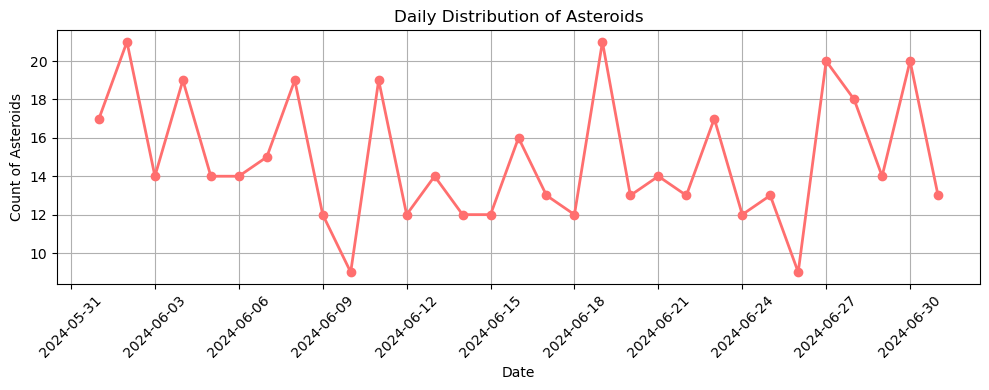

In [49]:
daily_asteroid_counts = df.groupby(df['close_approach_date_full'].dt.date).size()

plt.figure(figsize=(10, 4))
plt.plot(daily_asteroid_counts.index, daily_asteroid_counts.values, color='#FF6F6F', marker='o', linestyle='-', markersize=6, linewidth=2)
plt.title('Daily Distribution of Asteroids')
plt.xlabel('Date')
plt.ylabel('Count of Asteroids')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=3))
plt.grid(True)
plt.tight_layout()
plt.show()

**6. What are the average miss distances of the asteroids?**

To address this question, we will visualize the distribution of miss distances using a histogram. This graphical representation will provide insights into the frequency of various miss distances among the asteroids.

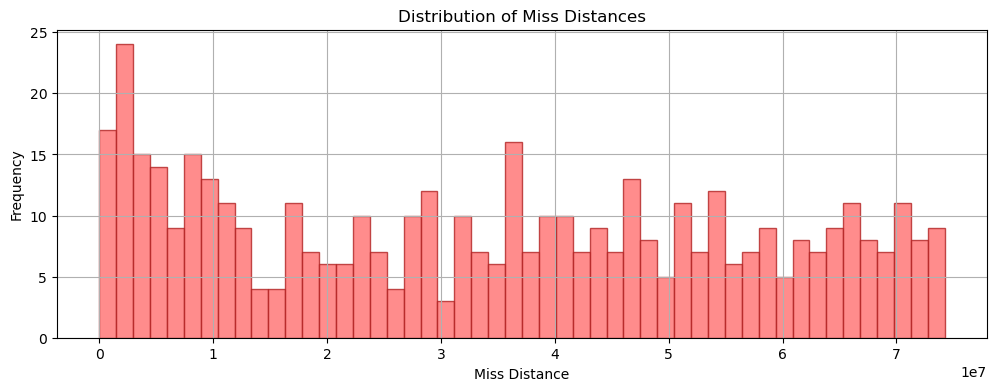

In [53]:
plt.figure(figsize=(12, 4))
plt.hist(df['miss_distance'], bins=50, color='#FF6F6F', edgecolor='#B22222', alpha=0.8)
plt.xlabel('Miss Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Miss Distances')
plt.grid(True)
plt.show()

## **Conclusion**
This project involved creating and analyzing a custom dataset using NASA's Asteroids - NeoWs API. We performed data cleaning, transformation, and analysis to explore asteroid characteristics and their potential risks. The results provided insights into correlations between various factors, such as momentum and hazard classification. Further exploration could involve expanding the dataset or applying advanced analytical techniques.